In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# using dataset : "Fashion MNIST" from kaggle
# totally 70000 examples, 50000/10000/10000 for training/dev/test set respectively

# used in kaggle notebook
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

train_dev_df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
test_df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

train_dev_X = train_dev_df.drop('label', axis=1).values / 255
train_dev_Y = train_dev_df['label'].values

Path to dataset files: /kaggle/input/fashionmnist


In [2]:
# train/dev split
np.random.seed(42)
train_size = 50000
dev_size = 10000
train_dev_size = train_size + dev_size
indices = np.random.permutation(train_dev_size)

train_X = train_dev_X[indices[:train_size]]
train_Y = train_dev_Y[indices[:train_size]]

dev_X = train_dev_X[indices[train_size:]]
dev_Y = train_dev_Y[indices[train_size:]]

test_X = test_df.drop('label', axis=1).values / 255
test_Y = test_df['label'].values

print(f"size of train X = {len(train_X)}")
print(f"size of train Y = {len(train_Y)}")
print(f"size of dev X = {len(dev_X)}")
print(f"size of dev Y = {len(dev_Y)}")
print(f"size of test X = {len(test_X)}")
print(f"size of test Y = {len(test_Y)}")

size of train X = 50000
size of train Y = 50000
size of dev X = 10000
size of dev Y = 10000
size of test X = 10000
size of test Y = 10000


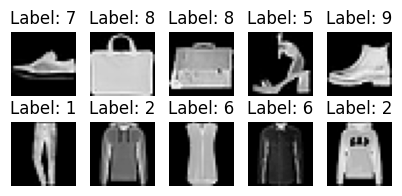

In [3]:
# plot examples
rows = 2
num_images = 5
image_width = 1
image_height = 1
image_size = (image_width * num_images, image_height * rows)

fig, axes = plt.subplots(rows, num_images, figsize=image_size)  
for i in range(rows * num_images):
    sample_image = train_X[i].reshape(28, 28)
    row, col = divmod(i, num_images)
    axes[row, col].imshow(sample_image, cmap='gray')
    axes[row, col].set_title(f'Label: {train_Y[i]}')
    axes[row, col].axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()  

In [4]:
# One-hot encoding
def one_hot_encode(Y, num_classes=10):
    m = Y.shape[0]
    one_hot = np.zeros((m, num_classes))
    one_hot[np.arange(m), Y] = 1
    return one_hot
    
train_Y = one_hot_encode(train_Y)
dev_Y = one_hot_encode(dev_Y)
test_Y = one_hot_encode(test_Y)

In [5]:
# NN architecture : Input (784) → Hidden Layer (128, ReLU) → Output Layer (10, softmax)

input_size = train_X.shape[1]
hidden_size = 128
output_size = 10

def initialize_parameters(input_size, hidden_size, output_size):
    # W[l].shape = (#units[l-1], #units[l])
    # b[l].shape = (1, #units[l])
    # can be improved by using Xavier/He initialization
    
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))
    
    parameters = {
        'W1':W1, 
        'b1':b1, 
        'W2':W2, 
        'b2':b2
    }
    return parameters


In [6]:
# implement activation functions
def relu(z):
    return np.maximum(0, z)
    
def softmax(z):
    exp_sum = np.sum(np.exp(z), axis=1, keepdims=True)
    return np.exp(z) / exp_sum

In [7]:
# implement forward propagation
def forward_prop(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    
    cache = {
        'Z1':Z1, 
        'A1':A1, 
        'Z2':Z2, 
        'A2':A2
    } 
    return cache
    

In [8]:
def cost_compute(Y, cache):
    # cross-entropy loss function
    m = Y.shape[0]
    y_pred = cache['A2']
    cost = -np.sum(Y * np.log(y_pred + 1e-8)) / m
    return cost

In [9]:
# implement backward propagation

def relu_derivative(Z):
    return Z > 0
    
def back_prop(X, Y, parameters, cache):
    
    m = X.shape[0]
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']
    Z2 = cache['Z2']
    
    
    dZ2 = A2 - Y  
    dW2 = np.dot(A1.T, dZ2) / m  
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m  # 計算對 b2 的梯度
    
    dA1 = np.dot(dZ2, W2.T)  
    dZ1 = dA1 * relu_derivative(Z1) 
    dW1 = np.dot(X.T, dZ1) / m 
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m  
    
    gradients = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }
    
    return gradients

In [10]:
# update parameters
def update_parameters(parameters, gradients, learning_rate=0.01):
    parameters['W1'] -= learning_rate * gradients['dW1']
    parameters['b1'] -= learning_rate * gradients['db1']
    parameters['W2'] -= learning_rate * gradients['dW2']
    parameters['b2'] -= learning_rate * gradients['db2']
    return parameters

In [12]:
parameters = initialize_parameters(input_size, hidden_size, output_size)
num_iterations = 5000
learning_rate = 0.01

def compute_accuracy(Y_true, Y_pred_probs):
    Y_true_labels = np.argmax(Y_true, axis=1)
    Y_pred_labels = np.argmax(Y_pred_probs, axis=1)
    return np.mean(Y_true_labels == Y_pred_labels)

for i in range(num_iterations):
    
    cache = forward_prop(train_X, parameters)
    
    cost = cost_compute(train_Y, cache)
    
    gradients = back_prop(train_X, train_Y, parameters, cache)
    
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    if i % 100 == 0:
        acc = compute_accuracy(train_Y, cache['A2']) * 100
        print(f"Iteration {i}, cost: {cost:.4f}, train accuracy: {acc:.4f}%")




Iteration 0, cost: 2.3013, train accuracy: 11.7780%
Iteration 100, cost: 2.2476, train accuracy: 28.9620%
Iteration 200, cost: 2.0813, train accuracy: 38.3280%
Iteration 300, cost: 1.7723, train accuracy: 46.1020%
Iteration 400, cost: 1.4969, train accuracy: 56.7420%
Iteration 500, cost: 1.3071, train accuracy: 60.3100%


KeyboardInterrupt: 